In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [162]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()

## Pretraitement

In [164]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)

## Prédiction de performance pour les coureurs en 2019

In [206]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    date_to_predict = race_to_predict.iloc[0]['date']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        has_run = 0
        total_distance = 0
        total_races = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        
        if runner_past.size > 0: 
            has_run = 1
            total_distance =  runner_past.equivalent_distance.sum()
            total_races = runner_past.shape[0]
            
            for i in range(len(runner_past)):
                ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,22] - 2010)
               
            last_year_df = runner_past.loc[runner_past.date > date_to_predict - pd.DateOffset(years=1)]
            if len(last_year_df) > 0:
                has_run_last_year = 1
                distance_previous_year = last_year_df.equivalent_distance.sum()
            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'total_distance': total_distance,
                        'distance_previous_year': distance_previous_year,
                        'total_races': total_races,
                        'has_run': has_run,
                        'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year,
                        'ranking_score': ranking_score
                       }, ignore_index = True)
        
        
    actual_values = join.loc[join.race_year_id == race_year_id_to_predict][['runner_id','ranking','relative_ranking','time_in_seconds']]
    df = pd.merge(df, actual_values, left_on="runner_id", right_on="runner_id", how="left")
    
    return df

In [207]:
runner_p = runner_profile(join,race, 39881)

100%|███████████████████████████████████████| 1557/1557 [00:20<00:00, 74.35it/s]


In [208]:
runner_p

,runner_id,age,gender,nationality,total_distance,distance_previous_year,total_races,has_run,has_run_last_year,has_run_equivalent_course,avg_course_per_year,ranking_score,ranking,relative_ranking,time_in_seconds
0,CAPELLPauESPM30.0,30.0,M,ESP,741.80,229.9,3.0,1.0,1.0,1.0,1.500000,3.561264,1.0,0.000392,73147.0
1,THEVENARDXavierFRAM33.0,33.0,M,FRA,1579.93,512.0,6.0,1.0,1.0,1.0,1.000000,8.068447,2.0,0.000785,76076.0
2,HAWKERScottNZLM34.0,34.0,M,NZL,532.28,0.0,2.0,1.0,0.0,1.0,0.666667,0.198562,3.0,0.001177,78484.0
3,OWENSTomGBRM40.0,40.0,M,GBR,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.0,0.001569,79469.0
4,SYMONDSAndyGBRM40.0,40.0,M,GBR,268.40,0.0,1.0,1.0,0.0,1.0,0.000000,0.121619,5.0,0.001962,81315.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,CHUILokNinJoeHKGM42.0,42.0,M,HKG,483.80,0.0,2.0,1.0,0.0,0.0,2.000000,0.024805,1552.0,0.608866,167493.0
1555,TSEHonShingHKGM62.0,62.0,M,HKG,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1553.0,0.609259,167494.0
1556,CLEMOTChristopheFRAM52.0,52.0,M,FRA,771.50,503.1,3.0,1.0,1.0,1.0,1.500000,0.014862,1554.0,0.609651,167592.0
1557,LOPEZHIDALGORafaelESPM43.0,43.0,M,ESP,1074.28,0.0,4.0,1.0,0.0,1.0,1.000000,0.008425,1555.0,0.610043,167813.0


<AxesSubplot:xlabel='axis1', ylabel='axis2'>

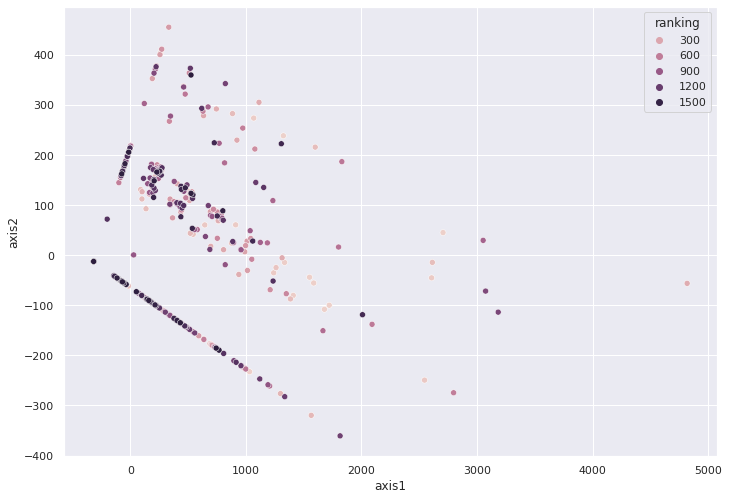

In [209]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = runner_p[['age','total_distance','distance_previous_year','total_races','has_run','has_run_last_year','has_run_equivalent_course','avg_course_per_year','ranking_score']]
cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X = pd.concat([X, join_test.gender, join_test.ranking, join_test.relative_ranking], axis=1)


sns.scatterplot(x = "axis1", y = "axis2",hue = 'ranking' ,data = X)

In [211]:
runner_p = runner_profile(join,race, 39881)

100%|███████████████████████████████████████| 1557/1557 [00:21<00:00, 71.05it/s]


# Test d'apprentissage KPPV

In [235]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as linalg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.linalg as linalg
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In [228]:
Z = runner_p[['runner_id','ranking','relative_ranking','time_in_seconds']]
X = runner_p.drop(columns=['runner_id','ranking','relative_ranking','time_in_seconds'])

In [229]:
time_mean = Z.time_in_seconds.median() 
Z = Z.assign(
    flag = Z.time_in_seconds > time_mean
)

In [251]:
X = X.drop(columns=['gender','nationality'])

In [247]:
y = Z['flag'].astype(int)

In [264]:
from sklearn.model_selection import GridSearchCV
param_grid ={
    'n_neighbors' : [a for a in range(2,200)]
}
estimator = KNeighborsClassifier()

In [254]:
clf = GridSearchCV(estimator, param_grid)
res_GS = clf.fit(X,y)

In [255]:
res_GS.best_params_

{'n_neighbors': 100}

<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

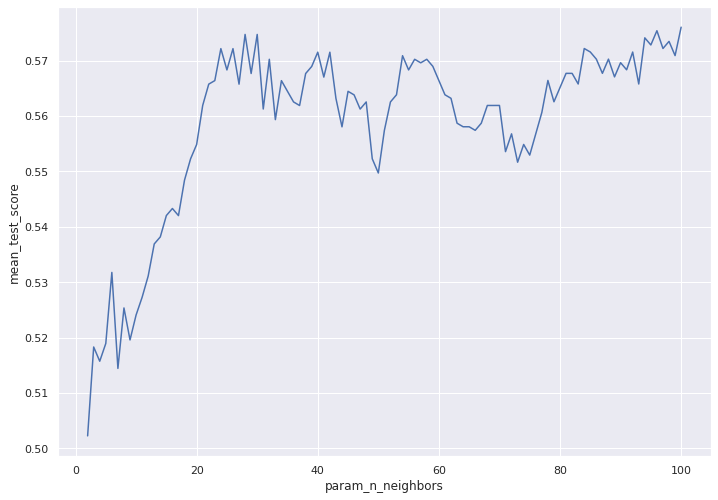

In [256]:
sns.lineplot(
    x ='param_n_neighbors', 
    y = 'mean_test_score', 
    data = res_GS.cv_results_
)

In [261]:
cls = KNeighborsClassifier(n_neighbors=100)
cls.fit(X,y)
labels = cls.predict(X)

In [262]:
from sklearn.metrics import accuracy_score


In [263]:
accuracy_score(y, labels)

0.581783194355356